In [2]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [5]:
from src.nas.chromosome import ChromosomeConfig
from src.nas.mlp_chromosome import MLPChromosome

ch_cfg = ChromosomeConfig(MLPChromosome)
low, high = ch_cfg.get_bounds()
low, high, ch_cfg.get_size()


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 6, 7, 6, 7, 6, 7, 7, 3, 4, 0, 0, 0, 2, 6, 3]),
 17)

In [8]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas_params import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    epochs=15,
    patience=5,
    amount_of_evaluations=1,
    population_size=30,
    population_offspring_count=10,
    algorithm_generations=1,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

(64.8, 25228.8)

In [9]:
plow = problem.get_nn_params(ch_cfg.decode(low))
phigh = problem.get_nn_params(ch_cfg.decode(high))

plow.get_complexity(), phigh.get_complexity()

(64.8, 25228.8)

In [10]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file `VertebralDataset_population.csv` is empty. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      4 |             - |             -
Solutions: [[6 2 3 1 3 0 1 5 5 0 0 0 0 0 2 2 3]
 [4 0 0 4 4 1 2 0 2 0 4 0 0 0 0 3 2]
 [6 0 4 2 6 2 0 5 4 0 0 0 0 0 0 4 0]
 [2 0 2 6 5 4 0 5 0 2 4 0 0 0 0 6 2]]
Objectives: [[-0.91935484  0.05209293]
 [-0.70967742  0.00340411]
 [-0.79032258  0.00465413]
 [-0.69354839  0.00150634]]


In [11]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,91.935484,1375.666396,"{'layers': [{'height': 6, 'compression': NNPar...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[6, 2, 3, 1, 3, 0, 1, 5, 5, 0, 0, 0, 0, 0, 2, ..."
1,70.967742,150.460941,"{'layers': [{'height': 6, 'compression': NNPar...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[4, 0, 0, 4, 4, 1, 2, 0, 2, 0, 4, 0, 0, 0, 0, ..."
2,79.032258,181.916599,"{'layers': [{'height': 6, 'compression': NNPar...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[6, 0, 4, 2, 6, 2, 0, 5, 4, 0, 0, 0, 0, 0, 0, ..."
3,69.354839,102.705570,"{'layers': [{'height': 6, 'compression': NNPar...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[2, 0, 2, 6, 5, 4, 0, 5, 0, 2, 4, 0, 0, 0, 0, ..."


In [13]:
from pprint import pprint

ch = ch_cfg.decode(df.loc[0]["Chromosome"])
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            compression=<NNParamsCompMode.NBITS: 'nbits'>,
                                            bitwidth=7),
                              FCLayerParams(height=12,
                                            compression=<NNParamsCompMode.NONE: 'none'>,
                                            bitwidth=2),
                              FCLayerParams(height=12,
                                            compression=<NNParamsCompMode.NONE: 'none'>,
                                            bitwidth=1),
                              FCLayerParams(height=3,
                                            compression=<NNParamsCompMode.NONE: 'none'>,
                                            bitwidth=6)],
                      activation=ActivationParams(activation=<Activation.NONE: 'none'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                        

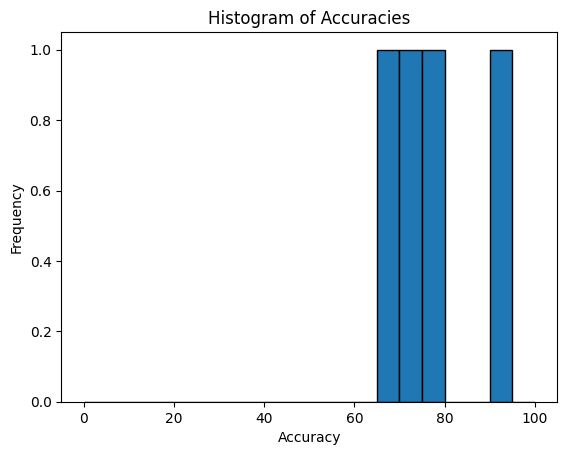

In [14]:
fig = hist_accuracies(df["Accuracy"])

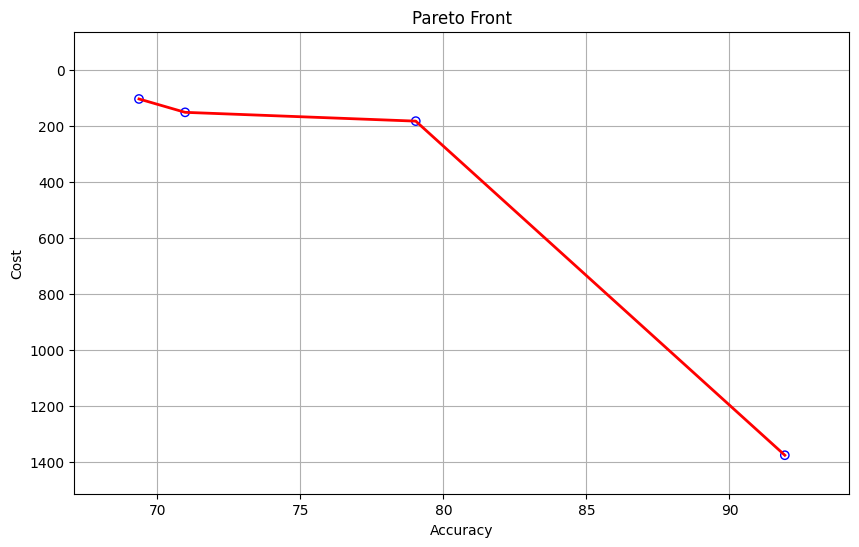

In [17]:
from src.nas import plot

fig = plot.plot_pareto_front(df["Accuracy"], df["Complexity"])

In [27]:
from src.models.eval import KFoldNNArchitectureEvaluator, NNArchitectureEvaluator

KFoldNNArchitectureEvaluator(problem.get_nn_params(ch)).evaluate_accuracy(times=3)

{'max': 90.3225806451613,
 'mean': np.float64(72.79569892473118),
 'std': np.float64(12.793439757192129),
 'accuracies': [74.19354838709677,
  74.19354838709677,
  70.96774193548387,
  35.483870967741936,
  75.80645161290323,
  75.80645161290323,
  54.83870967741935,
  70.96774193548387,
  66.12903225806451,
  75.80645161290323,
  80.64516129032258,
  82.25806451612904,
  90.3225806451613,
  79.03225806451613,
  85.48387096774194],
 'best_model': MLP(
   (layers): Sequential(
     (0): Quantize()
     (1): Linear(in_features=6, out_features=12, bias=True)
     (2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Dropout(p=0.2, inplace=False)
     (4): Identity()
     (5): Linear(in_features=12, out_features=12, bias=True)
     (6): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): Dropout(p=0.2, inplace=False)
     (8): Identity()
     (9): Linear(in_features=12, out_features=3, bias=True)
     (10): Batc

In [ ]:


accuracy, model = problem.best_models[tuple(df["Chromosome"].iloc[0])]

NNArchitectureEvaluator(params).test_model(model)

74.19354838709677